In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import gamma
from scipy.special import erfinv
from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk


from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

In [2]:
from matplotlib import font_manager
font_path = "/portal1/dell/li-b/font/ARIAL.TTF"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
# print(prop.get_name())  # 显示当前使用字体的名称

# 字体设置
plt.rcParams['font.family'] = 'ARIAL' # 使用字体中的无衬线体
# plt.rcParams['font.sans-serif'] = prop.get_name()  # 根据名称设置字体
# plt.rcParams['font.size'] = 10 # 设置字体大小
# plt.rcParams['axes.unicode_minus'] = False # 使坐标轴刻度标签正常显示正负号

In [2]:
inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
# inpath = '/portal1/dell/li-b/manu1/data/'
outpath = 'D:/figs_manu1/'
# outpath = '/portal1/dell/li-b/manu1/figs/'

In [3]:
x1 = xr.open_dataset(inpath+'shapley/pre_0.05.nc')
x2 = xr.open_dataset(inpath+'shapley/rn_0.05.nc').sel(time=slice('2001-01-01','2022-12-31'))
x3 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc')
x4 = xr.open_dataset(inpath+'shapley/t_0.05.nc').sel(time=slice('2001-01-01','2022-12-31'))
x5 = xr.open_dataset(inpath+'shapley/vpd_0.05.nc').sel(time=slice('2001-01-01','2022-12-31'))
# y1 = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc')
# y2 = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc')
# y3 = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc')

x3['vari'] = x3['vari'].where(x3['vari'] <= 1)
# y2['vari'] = y2['vari'].where(y2['vari'] >= 0)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## spi1 & spi3

In [3]:
ds = xr.open_dataset(inpath+"shapley/pre_0.05.nc")
precip_daily = ds['vari']

# Resample to monthly
precip_monthly = precip_daily.resample(time='ME').sum(skipna=True)
precip_monthly_rolled = precip_monthly.rolling(time=1, center=False).sum()
precip_np = precip_monthly_rolled.values
time = precip_monthly.time
lat = precip_monthly.lat
lon = precip_monthly.lon

# Prepare empty output
spi = np.full_like(precip_np, np.nan)

for i in range(precip_np.shape[1]):      # lat
    for j in range(precip_np.shape[2]):  # lon
        series = precip_np[:, i, j]

        # Skip if all NaNs
        if np.isnan(series).all():
            continue

        # Remove NaNs and zeros (Gamma cannot handle zeros)
        valid = (~np.isnan(series)) & (series > 0)
        valid_series = series[valid]

        if len(valid_series) < 24:  # minimum length threshold
            continue

        try:
            # Fit Gamma: loc fixed at 0
            alpha, loc, beta = gamma.fit(valid_series, floc=0)

            # Compute CDF
            cdf_vals = gamma.cdf(series[valid], a=alpha, loc=0, scale=beta)

            # Convert CDF to standard normal
            spi_vals = np.full(series.shape, np.nan)
            spi_vals[valid] = np.sqrt(2) * erfinv(2 * cdf_vals - 1)

            spi[:, i, j] = spi_vals

        except Exception as e:
            print(f"Failed at lat={i}, lon={j}: {e}")

valid_time = time[0:]
spi_trimmed = spi[0:, :, :]  # Match the shape

spi_da = xr.DataArray(
    data=spi_trimmed,
    coords={"time": valid_time, "lat": lat, "lon": lon},
    dims=["time", "lat", "lon"],
    name="vari"
)

# Wrap in a Dataset
spi_ds = xr.Dataset({"vari": spi_da})

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
a1 = spi_ds['vari'].sel(time='2022-07-31').values
a2 = np.flip(a1, axis=0)
b1 = spi_ds['vari'].sel(time='2022-08-31').values
b2 = np.flip(b1, axis=0)
c1 = spi_ds['vari'].sel(time='2022-09-30').values
c2 = np.flip(c1, axis=0)

shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

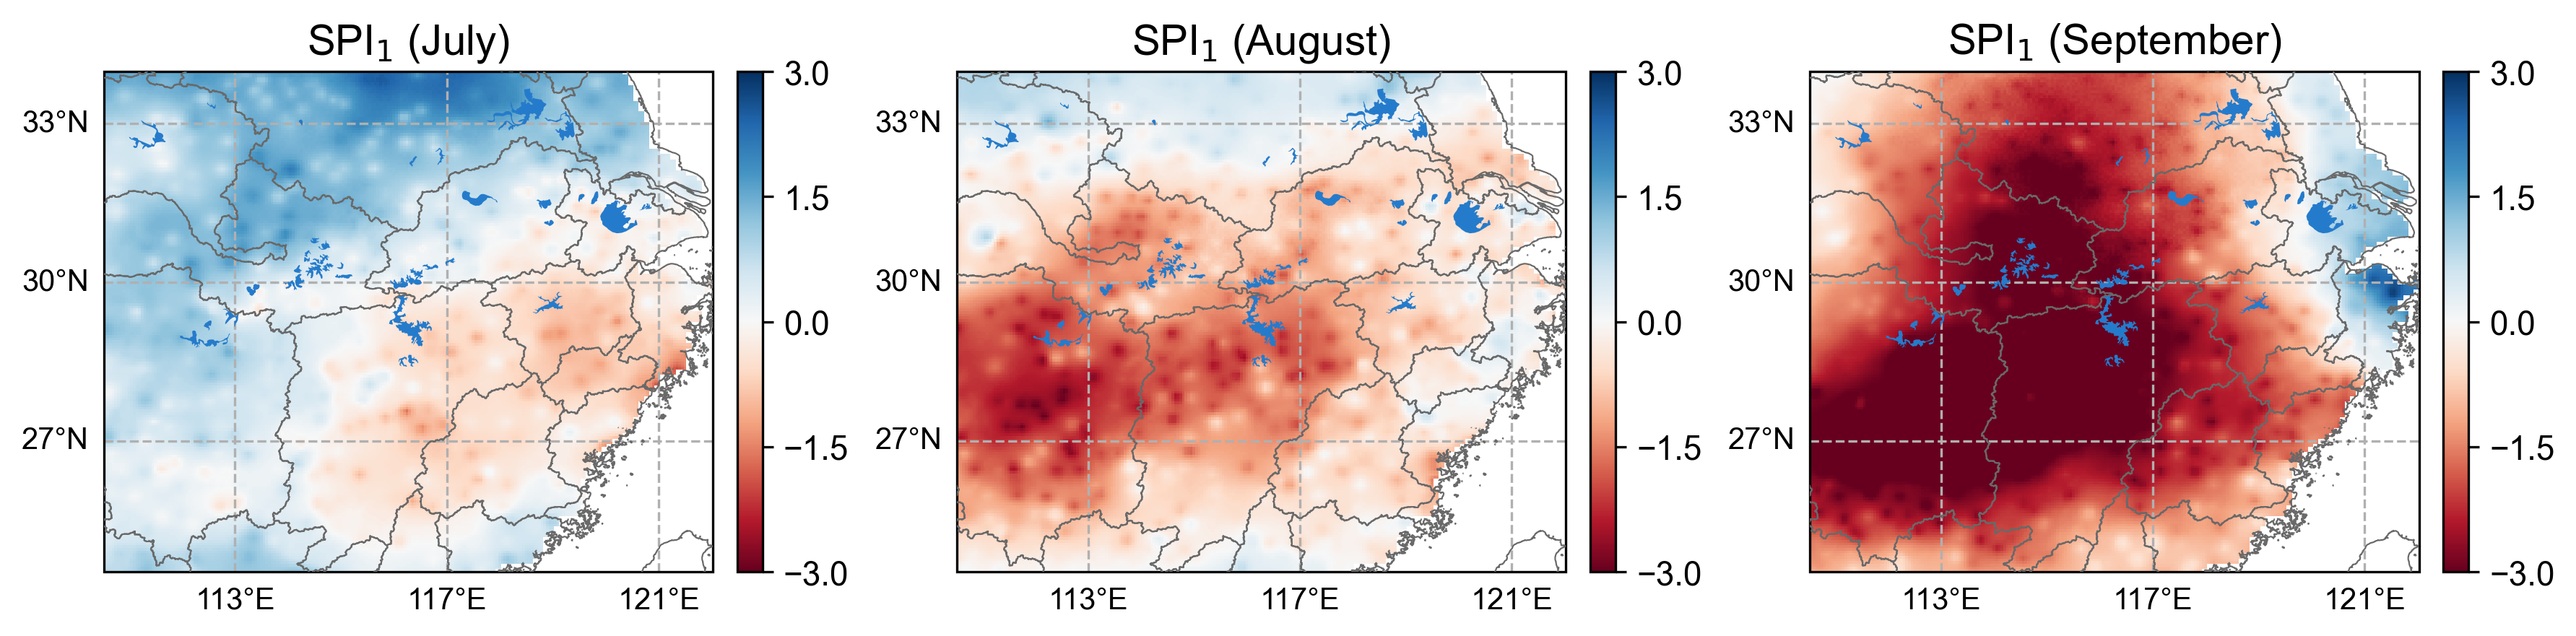

In [6]:
latitude, longitude = spi_ds.lat.values, spi_ds.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

axes_flat = axes.flatten()
data = [a2, b2, c2]  # Replace with your actual data for the subplots
title = ['SPI$_1$ (July)', 'SPI$_1$ (August)','SPI$_1$ (September)']
label = ['', '','']
vmax = [3,3,3]
vmin = [-3,-3,-3]
cmap = ['RdBu', 'RdBu', 'RdBu']
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.set_extent(extent, crs=ccrs.Geodetic())
        pcm = ax.pcolormesh(lon_lc, lat_lc, data[i], transform=ccrs.PlateCarree(), cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
        gridlines = ax.gridlines(draw_labels=True, linestyle='--')
        gridlines.xlabels_top = None
        gridlines.ylabels_right = None
        gridlines.xlocator = mticker.FixedLocator(x_ticks)
        gridlines.ylocator = mticker.FixedLocator(y_ticks)
        # Read and plot the boundary shapefile
        reader_bound = shapereader.Reader(shp_bound)
        geometries_bound = list(reader_bound.geometries())
        ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
        ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
        ax.set_title(title[i], fontsize=14)
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
        ticks = np.linspace(vmin[i], vmax[i], 5)
        cbar.set_ticks(ticks)
        cbar.set_label(label[i], fontsize=11, labelpad=0.5)
        cbar.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
# plt.tight_layout()
plt.savefig(outpath+'r1_1.eps', dpi=300, bbox_inches='tight') 
plt.show()

In [11]:
count_below_minus2 = np.sum((c1 <= -1) & ~np.isnan(c1))
total = np.sum(~np.isnan(c1))
percent = count_below_minus2/total*100
percent

76.87980595551427

In [3]:
ds = xr.open_dataset(inpath+"shapley/pre_0.05.nc")
precip_daily = ds['vari']

# Resample to monthly
precip_monthly = precip_daily.resample(time='ME').sum(skipna=True)
precip_monthly_rolled = precip_monthly.rolling(time=3, center=False).sum()
precip_np = precip_monthly_rolled.values
time = precip_monthly.time
lat = precip_monthly.lat
lon = precip_monthly.lon

# Prepare empty output
spi = np.full_like(precip_np, np.nan)

for i in range(precip_np.shape[1]):      # lat
    for j in range(precip_np.shape[2]):  # lon
        series = precip_np[:, i, j]

        # Skip if all NaNs
        if np.isnan(series).all():
            continue

        # Remove NaNs and zeros (Gamma cannot handle zeros)
        valid = (~np.isnan(series)) & (series > 0)
        valid_series = series[valid]

        if len(valid_series) < 24:  # minimum length threshold
            continue

        try:
            # Fit Gamma: loc fixed at 0
            alpha, loc, beta = gamma.fit(valid_series, floc=0)

            # Compute CDF
            cdf_vals = gamma.cdf(series[valid], a=alpha, loc=0, scale=beta)

            # Convert CDF to standard normal
            spi_vals = np.full(series.shape, np.nan)
            spi_vals[valid] = np.sqrt(2) * erfinv(2 * cdf_vals - 1)

            spi[:, i, j] = spi_vals

        except Exception as e:
            print(f"Failed at lat={i}, lon={j}: {e}")

valid_time = time[2:]
spi_trimmed = spi[2:, :, :]  # Match the shape

spi_da = xr.DataArray(
    data=spi_trimmed,
    coords={"time": valid_time, "lat": lat, "lon": lon},
    dims=["time", "lat", "lon"],
    name="vari"
)

# Wrap in a Dataset
spi_ds = xr.Dataset({"vari": spi_da})

a1 = spi_ds['vari'].sel(time='2022-07-31').values
a2 = np.flip(a1, axis=0)
b1 = spi_ds['vari'].sel(time='2022-08-31').values
b2 = np.flip(b1, axis=0)
c1 = spi_ds['vari'].sel(time='2022-09-30').values
c2 = np.flip(c1, axis=0)



shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
count_below_minus2 = np.sum((c1 <= 0) & ~np.isnan(c1))
total = np.sum(~np.isnan(c1))
percent = count_below_minus2/total*100
percent

72.66346699695515

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

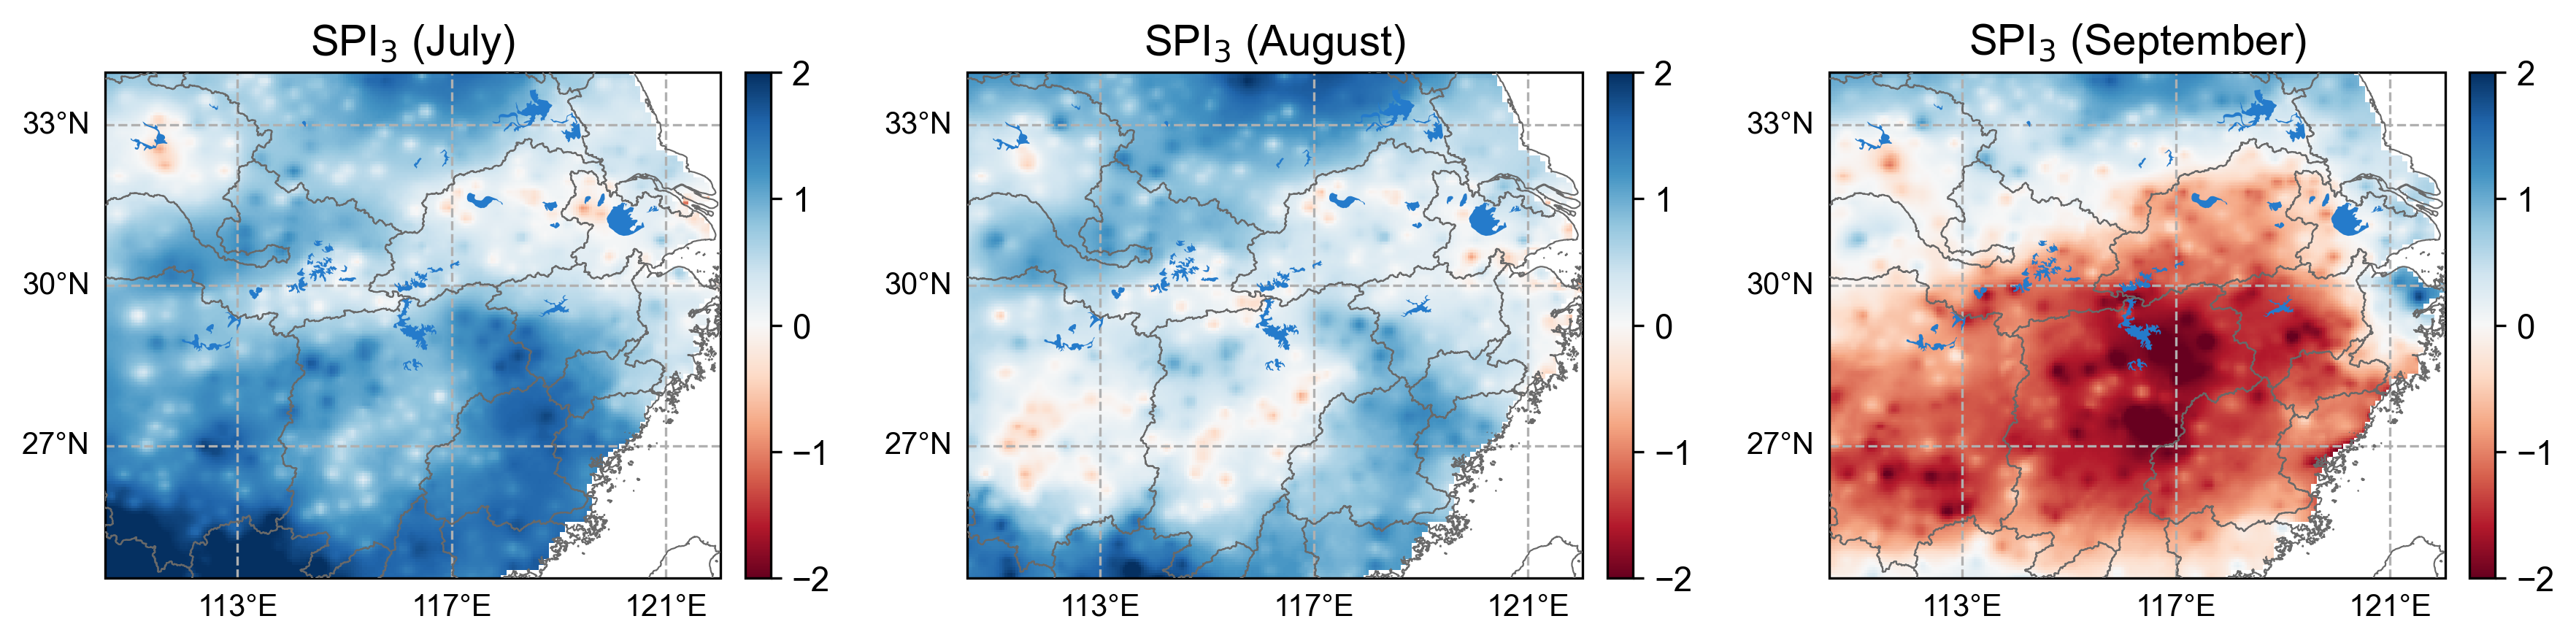

In [ ]:
latitude, longitude = spi_ds.lat.values, spi_ds.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

axes_flat = axes.flatten()
data = [a2, b2, c2]  # Replace with your actual data for the subplots
title = ['SPI$_3$ (July)', 'SPI$_3$ (August)','SPI$_3$ (September)']
label = ['', '','']
vmax = [2,2,2]
vmin = [-2,-2,-2]
cmap = ['RdBu', 'RdBu', 'RdBu']
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.set_extent(extent, crs=ccrs.Geodetic())
        pcm = ax.pcolormesh(lon_lc, lat_lc, data[i], transform=ccrs.PlateCarree(), cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
        gridlines = ax.gridlines(draw_labels=True, linestyle='--')
        gridlines.xlabels_top = None
        gridlines.ylabels_right = None
        gridlines.xlocator = mticker.FixedLocator(x_ticks)
        gridlines.ylocator = mticker.FixedLocator(y_ticks)
        # Read and plot the boundary shapefile
        reader_bound = shapereader.Reader(shp_bound)
        geometries_bound = list(reader_bound.geometries())
        ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
        ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
        ax.set_title(title[i], fontsize=14)
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
        ticks = np.linspace(vmin[i], vmax[i], 5)
        cbar.set_ticks(ticks)
        cbar.set_label(label[i], fontsize=11, labelpad=0.5)
        cbar.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
# plt.tight_layout()
plt.savefig(outpath+'r1_2.eps', dpi=300, bbox_inches='tight') 
plt.show()

## sm 7, 8, 9

In [9]:
ds0 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time=slice('2016-01-01','2022-12-31'))
ds_m = ds0.resample(time='M').mean(skipna=True)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [10]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)
    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            anos[:,j,i] = v1 - v1.mean()
    times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [11]:
def cal_1month_ano_aver(ds1, mon1):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)
    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            anos[:,j,i] = v1 - v1.mean()
    times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [12]:
ds_jul = cal_1month_ano_aver(ds_m, 7)
ds_aug = cal_1month_ano_aver(ds_m, 8)
ds_sep = cal_1month_ano_aver(ds_m, 9)
ds_jas = cal_3month_ano_aver(ds_m, 7, 8, 9)

C:\Users\bn_li\AppData\Local\Temp\ipykernel_7920\1757467554.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_7920\1757467554.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_7920\1757467554.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_7920\2844765677.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start='2016-12-31', end='2022-12-31', freq='Y')


In [13]:
ds_jas.to_netcdf(inpath+'anos/sm_ano.nc')

In [14]:
a = ds_jul
a1 = a['vari'][6,:,:].values*100
a2 = np.flip(a1, axis=0)
b = ds_aug
b1 = b['vari'][6,:,:].values*100
b2 = np.flip(b1, axis=0)
c = ds_sep
c1 = c['vari'][6,:,:].values*100
c2 = np.flip(c1, axis=0)


shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

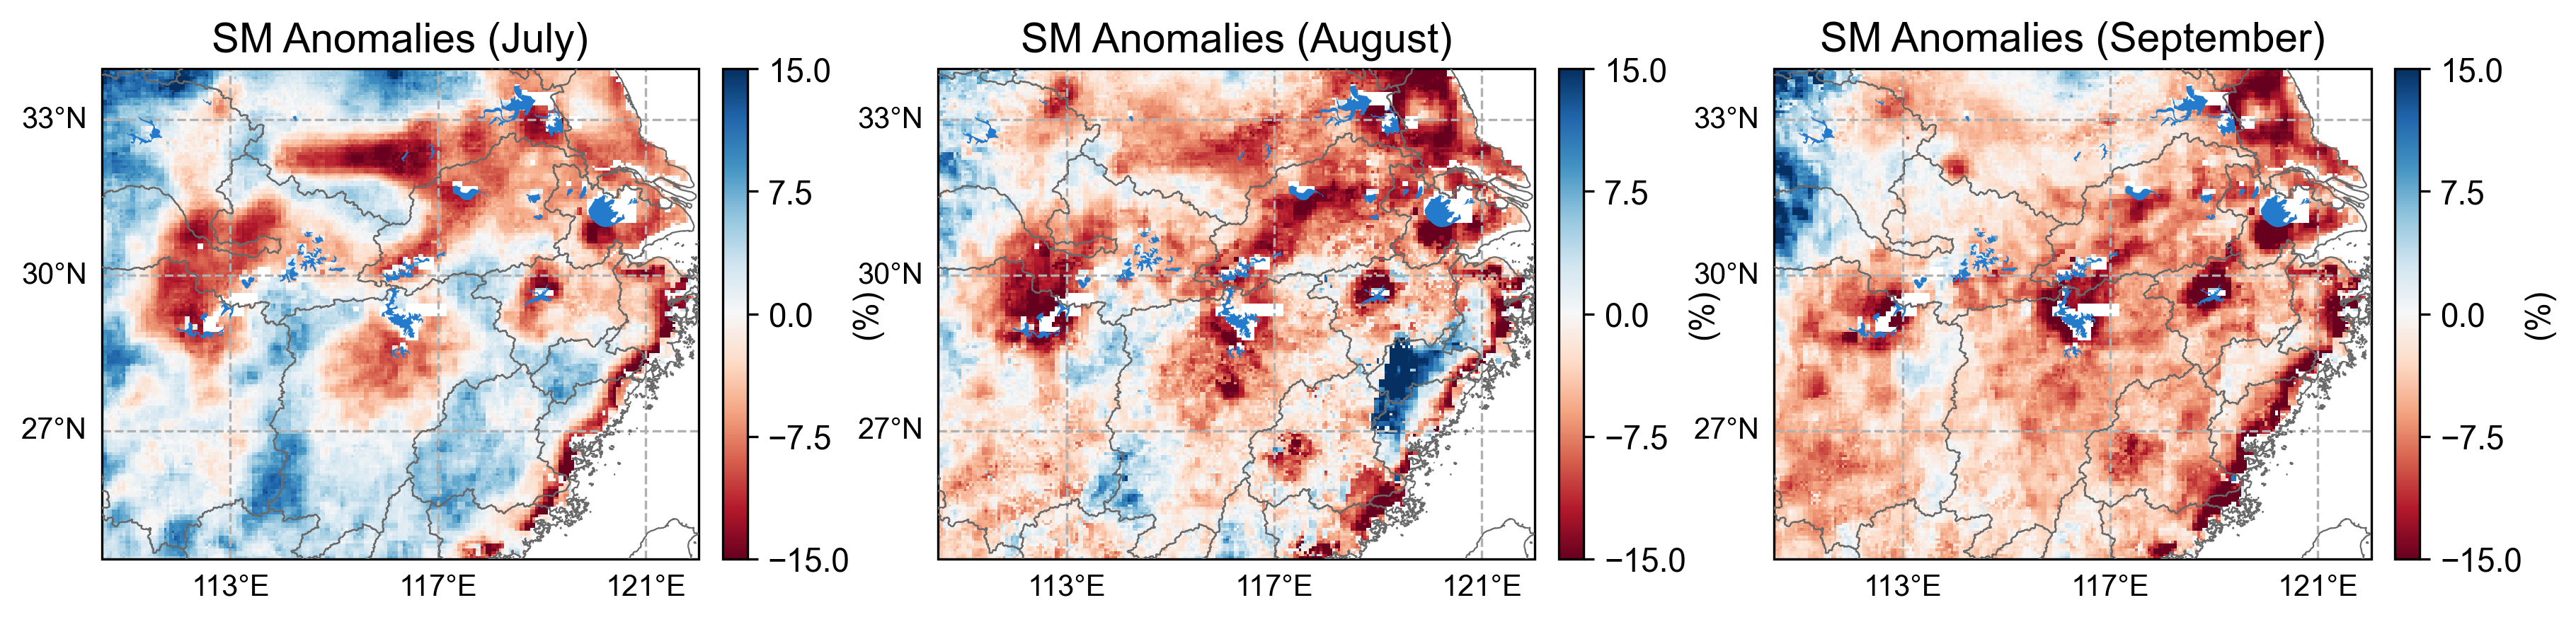

In [15]:
latitude, longitude = a.lat.values, a.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

axes_flat = axes.flatten()
data = [a2, b2, c2]  # Replace with your actual data for the subplots
title = ['SM Anomalies (July)', 'SM Anomalies (August)','SM Anomalies (September)']
label = ['(%)', '(%)','(%)']
vmax = [15,15,15]
vmin = [-15,-15,-15]
cmap = ['RdBu', 'RdBu', 'RdBu']
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.set_extent(extent, crs=ccrs.Geodetic())
        pcm = ax.pcolormesh(lon_lc, lat_lc, data[i], transform=ccrs.PlateCarree(), cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
        gridlines = ax.gridlines(draw_labels=True, linestyle='--')
        gridlines.xlabels_top = None
        gridlines.ylabels_right = None
        gridlines.xlocator = mticker.FixedLocator(x_ticks)
        gridlines.ylocator = mticker.FixedLocator(y_ticks)
        # Read and plot the boundary shapefile
        reader_bound = shapereader.Reader(shp_bound)
        geometries_bound = list(reader_bound.geometries())
        ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
        ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
        ax.set_title(title[i], fontsize=14)
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
        ticks = np.linspace(vmin[i], vmax[i], 5)
        cbar.set_ticks(ticks)
        cbar.set_label(label[i], fontsize=11, labelpad=0.5)
        cbar.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
# plt.tight_layout()
plt.savefig(outpath+'r2_1.eps', dpi=300, bbox_inches='tight') 
plt.show()

## Datong discharge

C:\Users\bn_li\AppData\Local\Temp\ipykernel_2168\1001538126.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


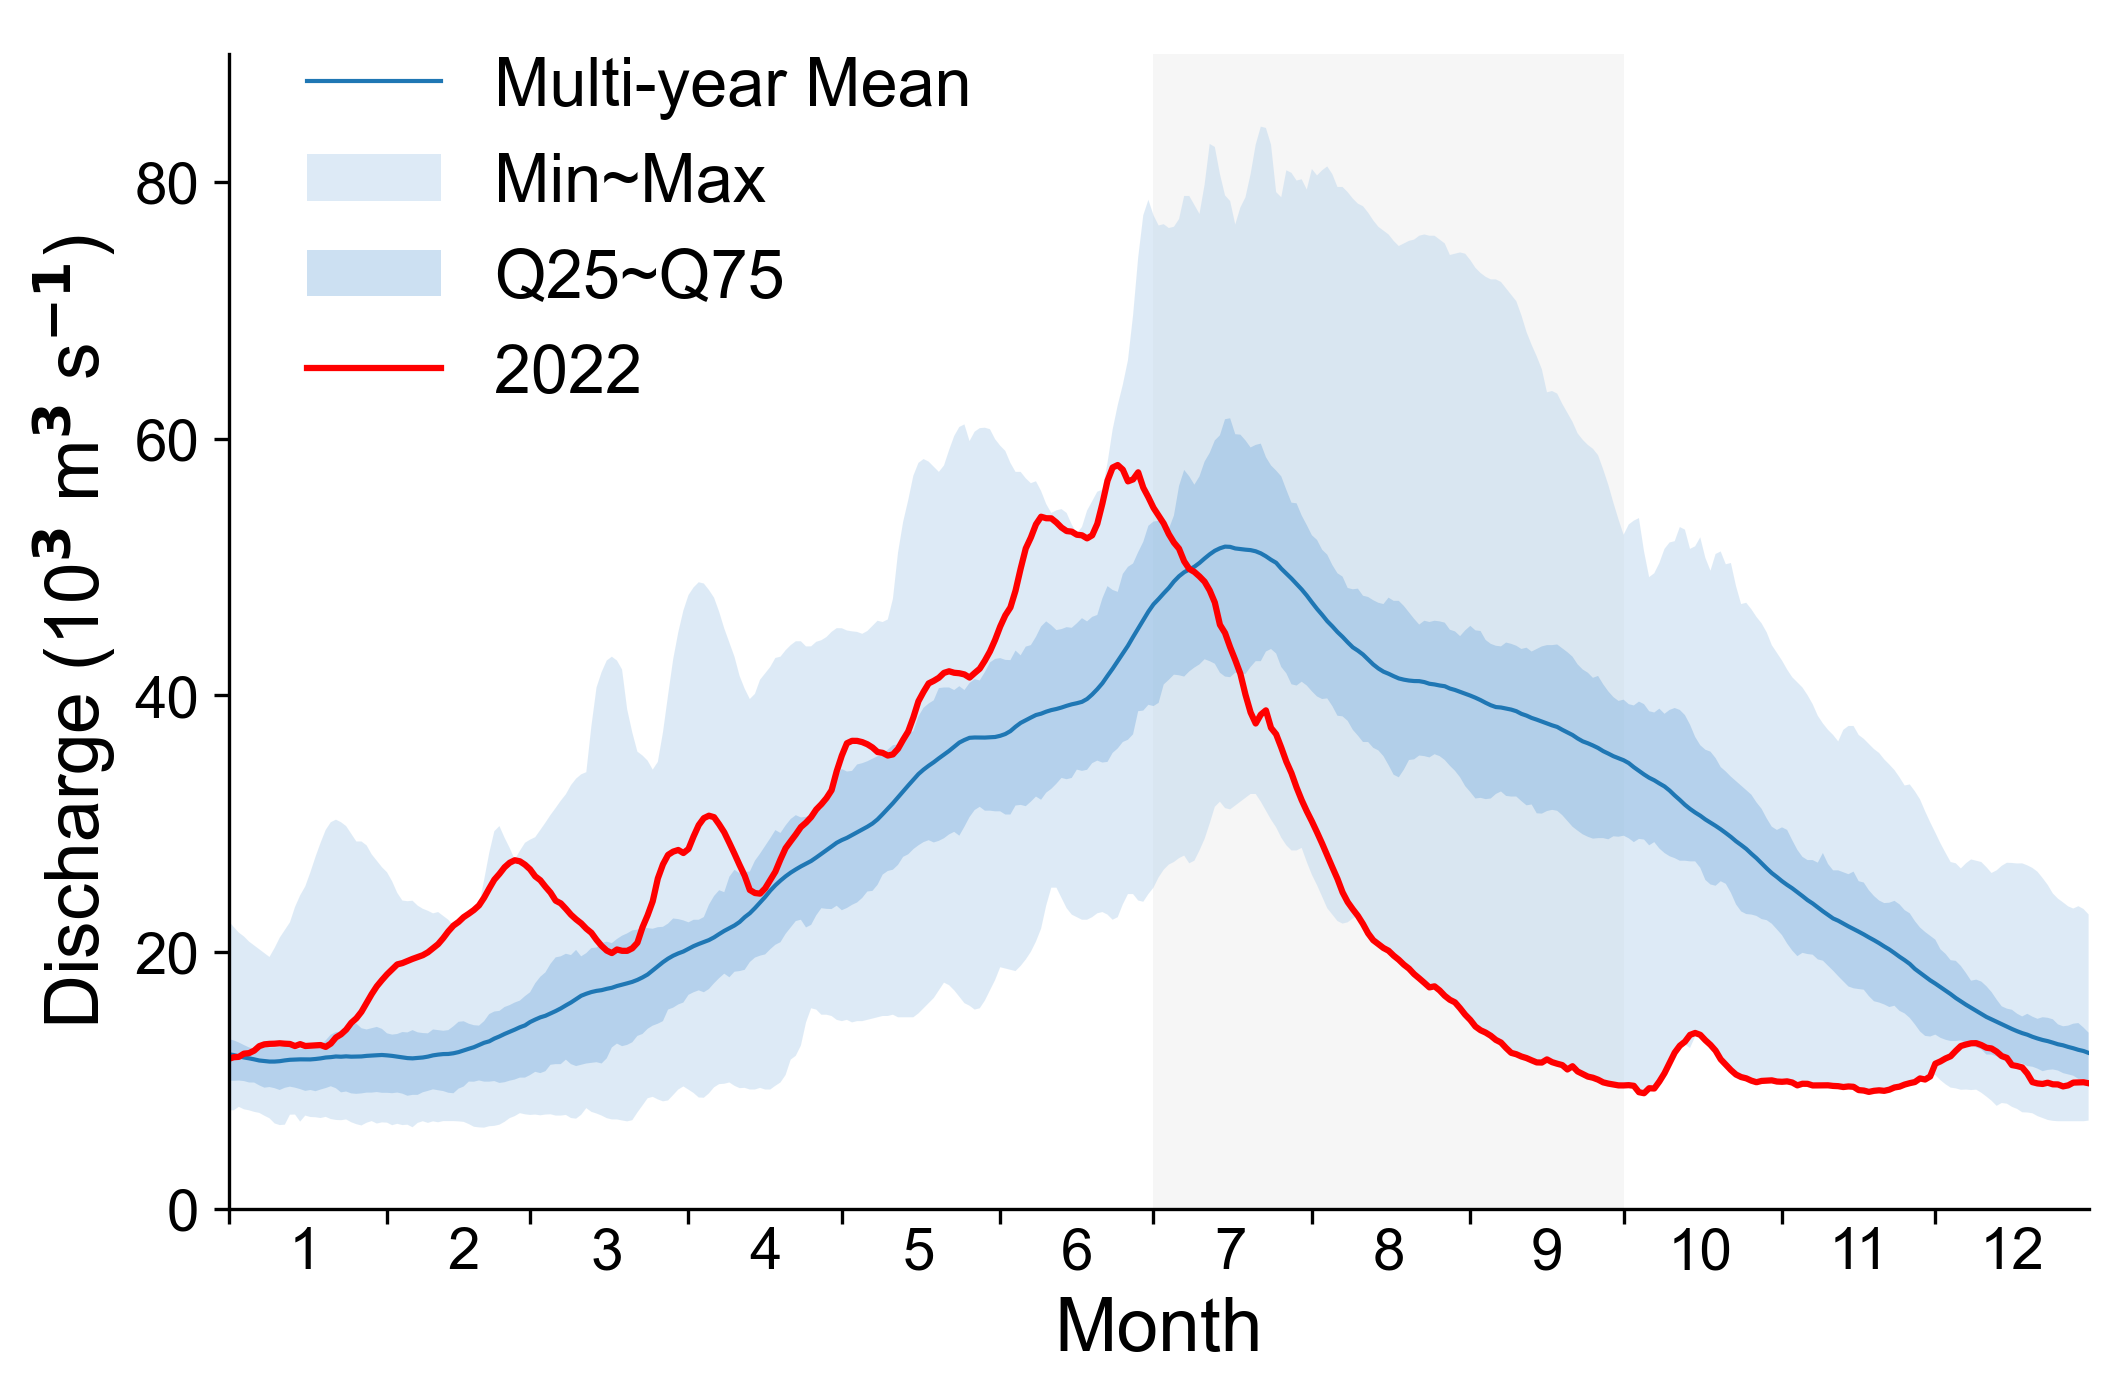

In [4]:
############## 1956-2022 #########################################################################
df = pd.read_csv(inpath+'Datong.csv')
df['TM'] = pd.to_datetime(df['TM'])
# IDX = [ (date.month!=2 or date.day!=29) for date in pd.to_datetime(df['TM'])]
dates = df['TM']
IDX = []
for date in dates:
    if (date.month==2 and date.day==29):
        IDX.append(False)
    else:
        IDX.append(True)
        
df_without_228 = df[IDX]
Q_list = df_without_228['Q'].values
Q_Mat = Q_list.reshape((365, -1), order='F')
Q_before = Q_Mat/1000
Q_2022 = Q_Mat[:,-1]/1000


fig, ax = plt.subplots(1,1,dpi=300,figsize=(8,5))
dd = np.arange(1,366)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
ax.plot(dd,np.nanmean(Q_before,axis=1),lw=1,ls='-',color='tab:blue', label='Multi-year Mean')
ax.fill_between(dd, np.nanmin(Q_before,axis=1),np.nanmax(Q_before,axis=1), color='#BDD7EE',alpha=0.5,label='Min~Max', edgecolor='none')
ax.fill_between(dd, np.nanpercentile(Q_before,q=25,axis=1),np.nanpercentile(Q_before,q=75,axis=1), color='#599AD7',alpha=0.3,label='Q25~Q75', edgecolor='none')
ax.plot(dd, Q_2022,color='r',lw=1.5,label='2022')
ax.set_xlim(dd[0], dd[-1])
ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
ax.set_xticklabels([])  # Clear the default labels since we will place them manually
new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
for label, pos in zip(xticklabels, new_positions):
    ax.text(pos, -3.5, label, ha='center', va='center', fontsize=14) 
ax.set_ylim(0,90)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Discharge (10$\mathbf{^{3}}$ m$\mathbf{^{3}}$ s$\mathbf{^{-1}}$)',fontsize=18)
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=16)
ax.set_xlabel('Month', fontsize=18, labelpad=14)

plt.savefig(outpath+'r3.eps', dpi=1000, bbox_inches='tight') 
plt.show()

## other hydroclimate variables

In [5]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m00 = ds1.resample(time='M').mean(skipna=True)
    ds_m0 = ds_m00.sel(time=ds_m00['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)
    anos1 = np.zeros_like(ds_m) #contain detrended and normalized anomalies
    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(start_year, end_year+1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing' or tr=='decreasing':
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                else:
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds1.lat.values),
                        'lon': (['lon'], ds1.lon.values)})
    return ds_ano

In [6]:
d = cal_3month_ano_aver(x2, 7, 8, 9, 2001, 2022)
e = cal_3month_ano_aver(x4, 7, 8, 9, 2001, 2022)
f = cal_3month_ano_aver(x5, 7, 8, 9, 2001, 2022)

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: un

In [7]:
d.to_netcdf(inpath+'anos/rn_ano.nc')
e.to_netcdf(inpath+'anos/t_ano.nc')
f.to_netcdf(inpath+'anos/vpd_ano.nc')

In [4]:
d = xr.open_dataset(inpath+'anos/rn_ano.nc')
e = xr.open_dataset(inpath+'anos/t_ano.nc')
f = xr.open_dataset(inpath+'anos/vpd_ano.nc')

In [5]:
c = xr.open_dataset(inpath+'anos/sm_ano.nc')
c1 = c['vari'][6,:,:].values*100
c2 = np.flip(c1, axis=0)
d1 = d['vari'][21,:,:].values / 10**6
d2 = np.flip(d1, axis=0)
e1 = e['vari'][21,:,:].values
e2 = np.flip(e1, axis=0)
f1 = f['vari'][21,:,:].values ##### kpa
f2 = np.flip(f1, axis=0)

shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

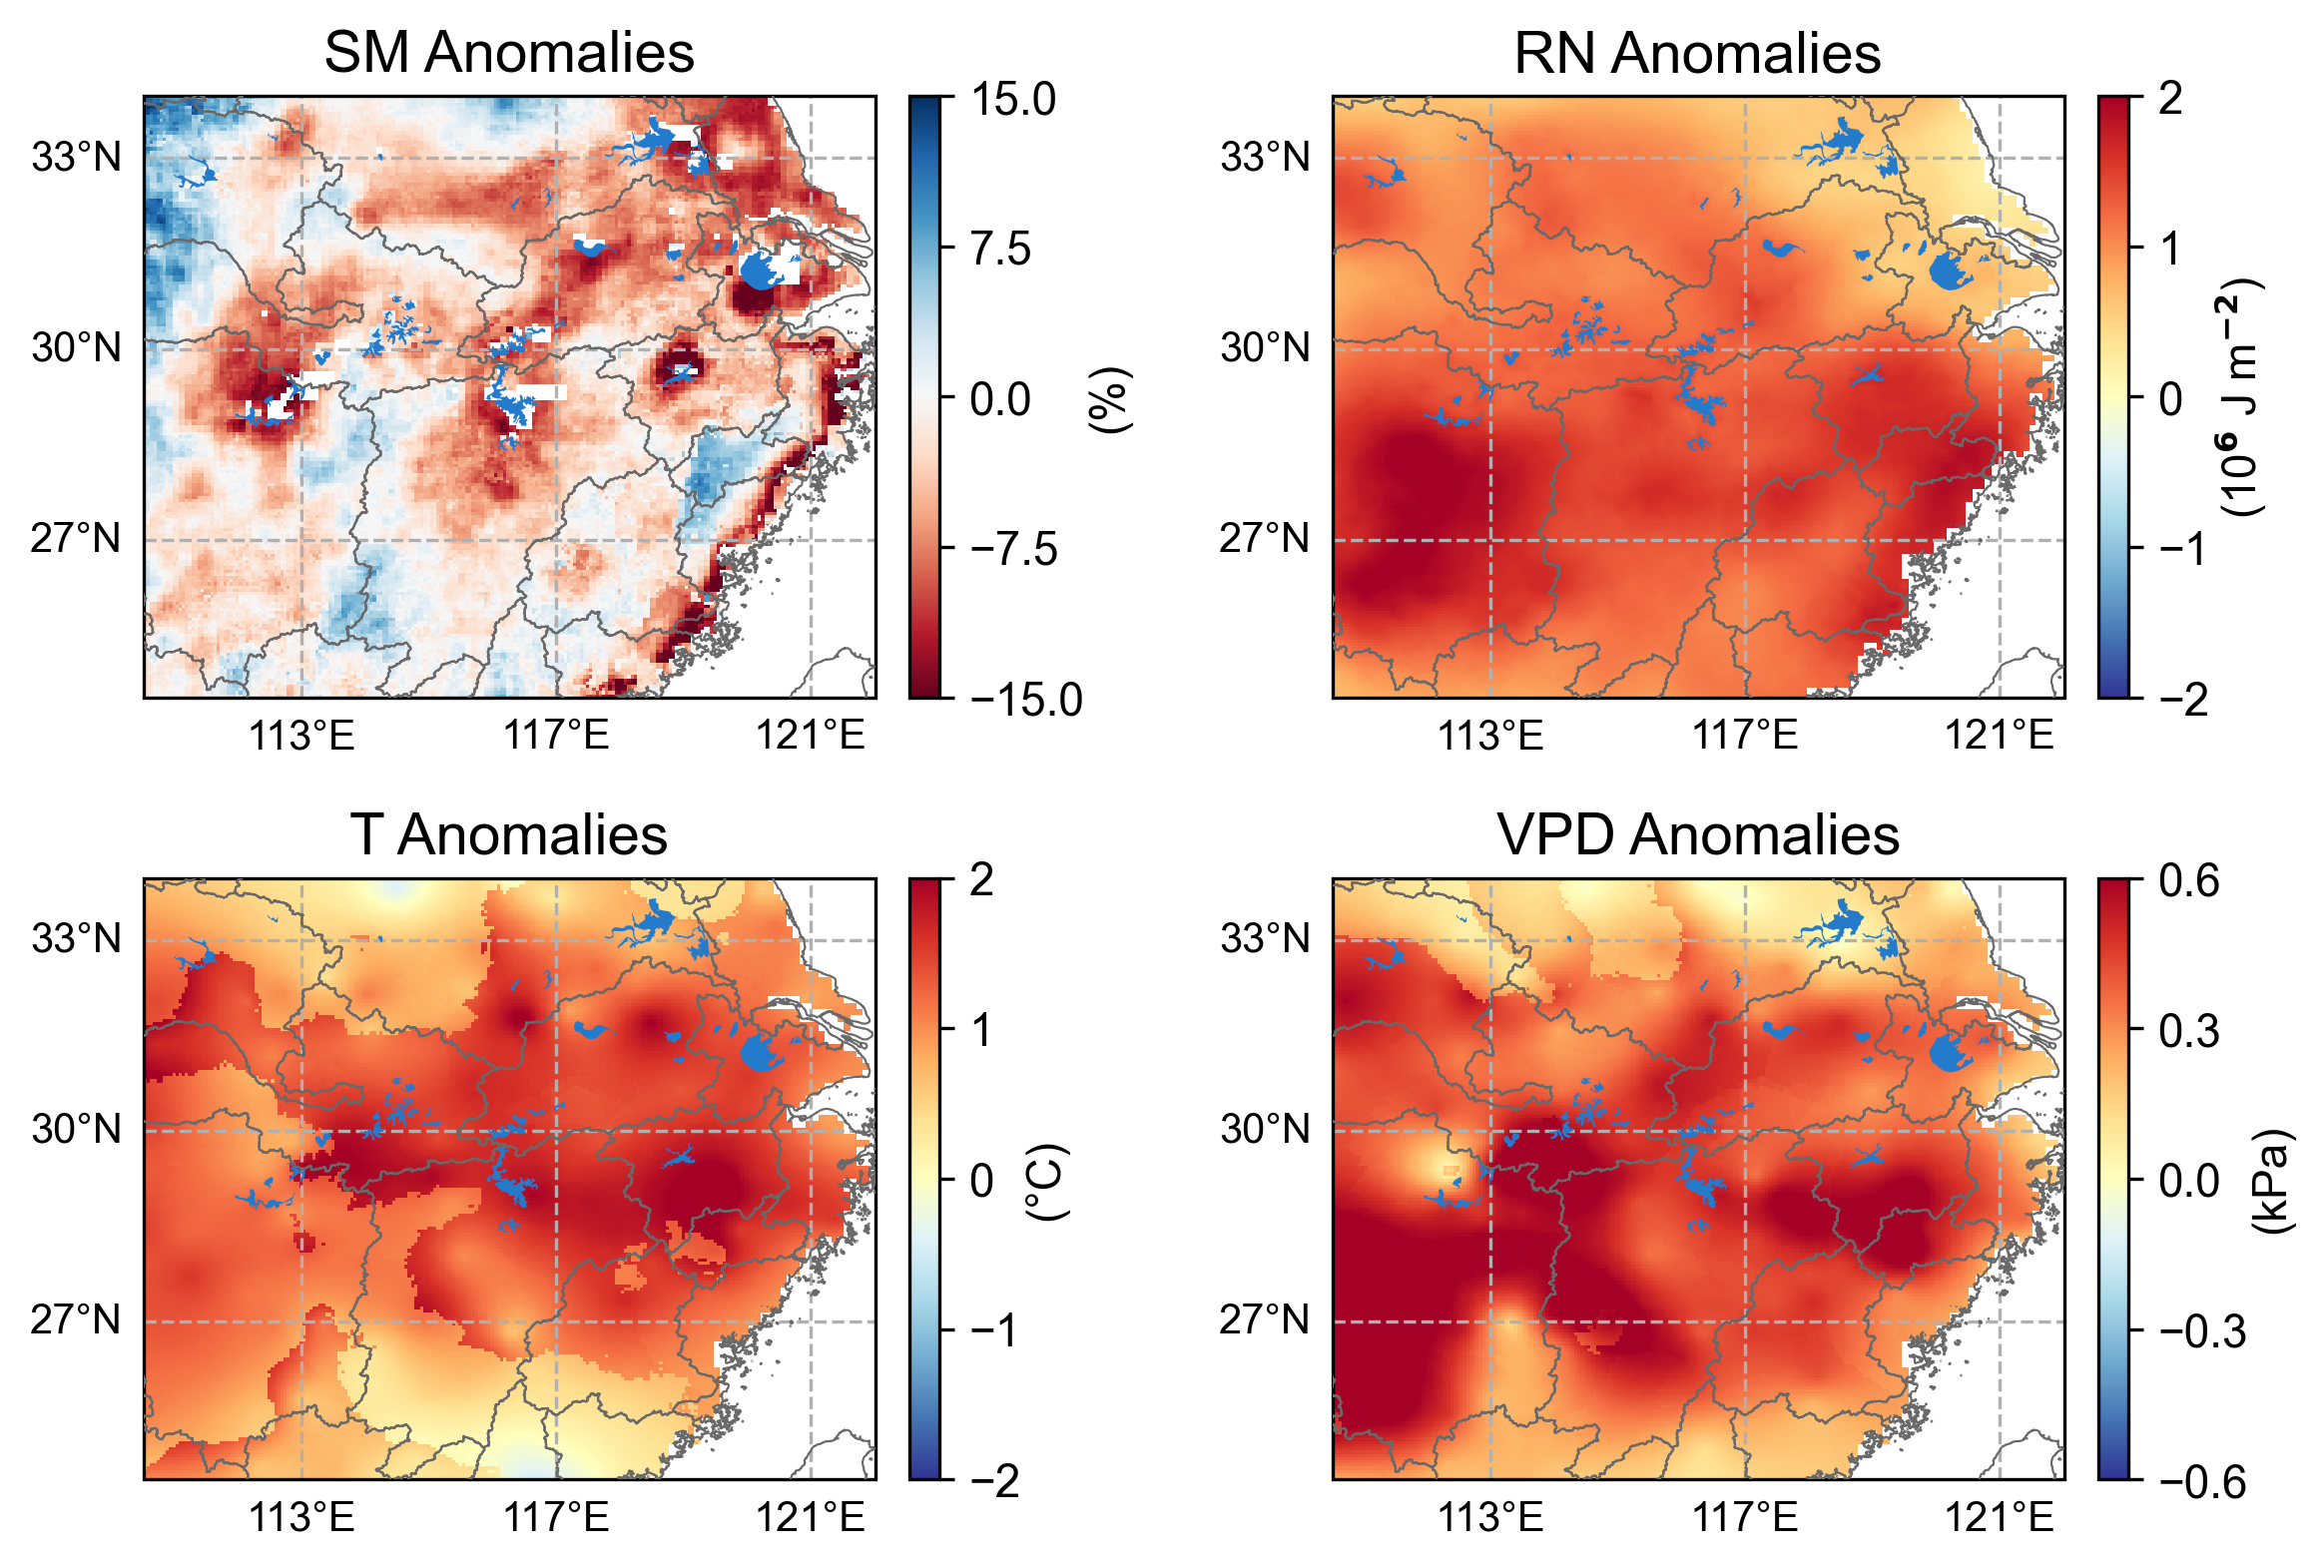

In [6]:
latitude, longitude = c.lat.values, c.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, axes = plt.subplots(2, 2, figsize=(10,6), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

axes_flat = axes.flatten()
data = [c2, d2, e2,f2]  # Replace with your actual data for the subplots
title = ['SM Anomalies','RN Anomalies','T Anomalies','VPD Anomalies']
label = ['(%)', '(10$\mathbf{^{6}}$ J m$\mathbf{^{-2}}$)','(°C)', '(kPa)']
vmax = [15,2.0, 2.0, 0.6]
vmin = [-15,-2.0, -2.0, -0.6]
cmap = ['RdBu', 'RdYlBu_r', 'RdYlBu_r', 'RdYlBu_r']
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.set_extent(extent, crs=ccrs.Geodetic())
        pcm = ax.pcolormesh(lon_lc, lat_lc, data[i], transform=ccrs.PlateCarree(), cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
        gridlines = ax.gridlines(draw_labels=True, linestyle='--')
        gridlines.xlabels_top = None
        gridlines.ylabels_right = None
        gridlines.xlocator = mticker.FixedLocator(x_ticks)
        gridlines.ylocator = mticker.FixedLocator(y_ticks)
        # Read and plot the boundary shapefile
        reader_bound = shapereader.Reader(shp_bound)
        geometries_bound = list(reader_bound.geometries())
        ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
        ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
        ax.set_title(title[i], fontsize=14)
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
        ticks = np.linspace(vmin[i], vmax[i], 5)
        cbar.set_ticks(ticks)
        cbar.set_label(label[i], fontsize=11, labelpad=0.5)
        cbar.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
# plt.tight_layout()
plt.savefig(outpath+'r4.eps', dpi=300, bbox_inches='tight') 
plt.show()